In [13]:
library(dplyr)
library(ggplot2)
library(zeallot)

In [14]:
analysis <- function(X, Y, display_plot=TRUE){
    spearman <- cor(X, Y, use="pairwise.complete.obs", method="spearman")
    pearson <- cor(X, Y, use="pairwise.complete.obs", method="pearson")
    print(c("Pearson", pearson))
    print(c("Spearman", spearman))
    if (display_plot) {
        ggplot() + geom_point(aes(x=X, y=Y))
    }
}

regression <- function(X, Y, display_plot=TRUE){
    r <- cor(X, Y, use="pairwise.complete.obs")
    Sx <- sd(X)
    Sy <- sd(Y)
    a <- r * Sy / Sx
    b <- mean(Y) - a * mean(X)

    if(display_plot){
        xs <- seq(min(X), max(X), 0.01)
        plt <- ggplot() +
            geom_point(aes(x=X, y=Y), alpha=0.5) +
            geom_line(aes(x = xs, y = a * xs + b), linewidth=1, col="red")
        show(plt)
    }

    return(c(a, b))
}

In [16]:
data <- read.csv("data/data.csv")
data2000 <- data %>% filter(year == 2000)
data2005 <- data %>% filter(year == 2005)
data2010 <- data %>% filter(year == 2010)
data2015 <- data %>% filter(year == 2015)
poland <- data %>% filter(country == "Poland")

[1] "Pearson"           "0.751975462736698"
[1] "Spearman"          "0.813541004769093"


Warning message:
"Removed 170 rows containing missing values (`geom_point()`)."


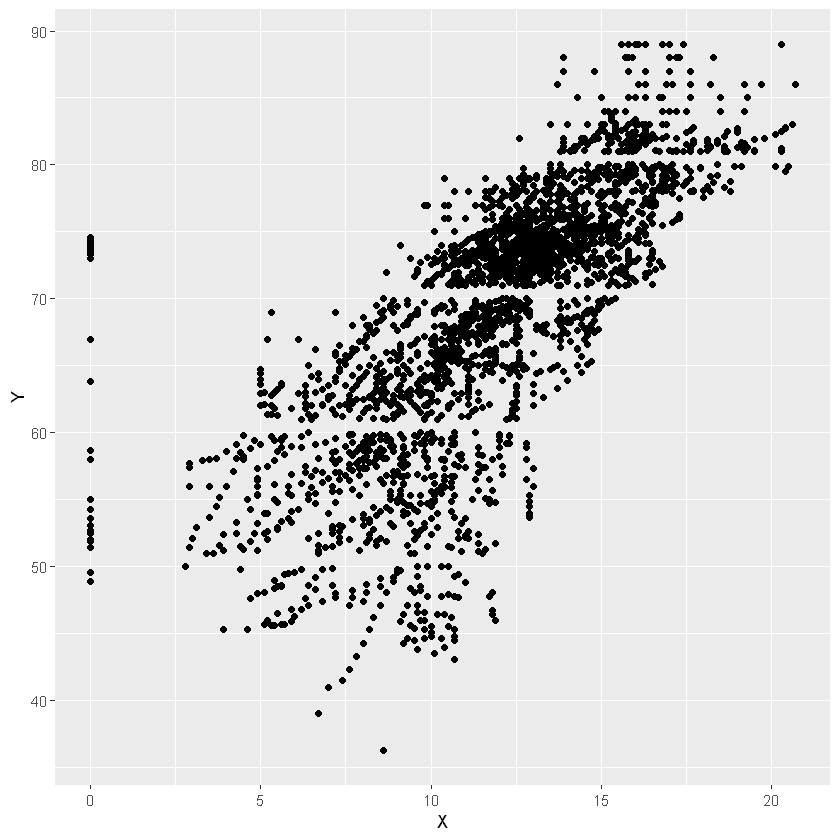

In [17]:
analysis(data$schooling, data$life_expectancy)

In [24]:
df <- data[!is.na(data$schooling) & !is.na(data$life_expectancy),]


In [29]:
length(data$schooling)

[1] 2938

In [30]:
length(data$life_expectancy)

[1] 2938

[1]  2.103453 44.108889

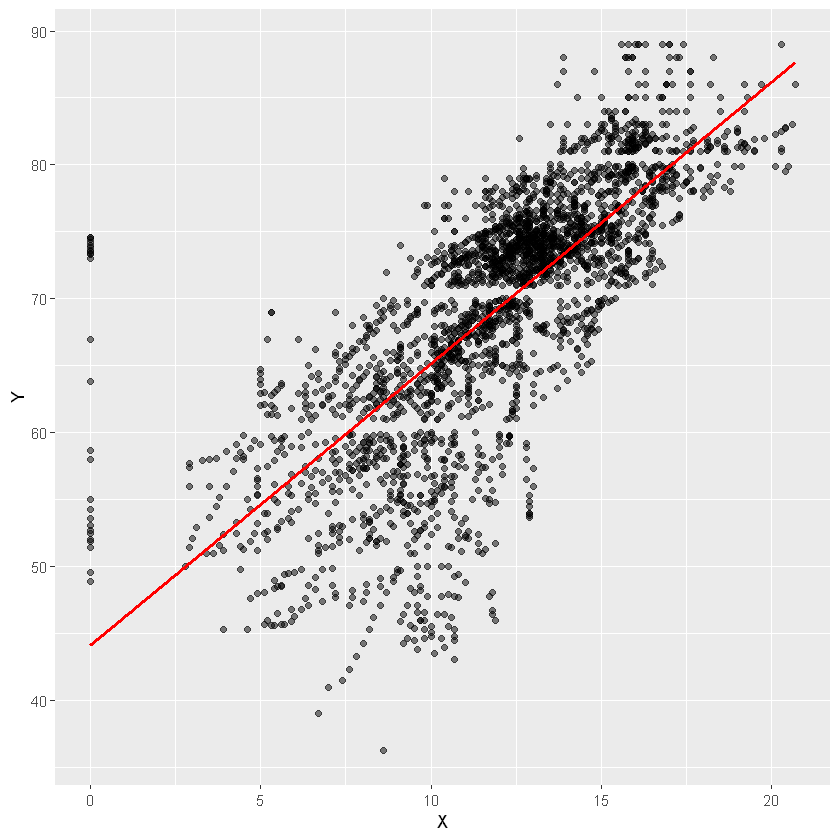

In [21]:
regression(df$schooling, df$life_expectancy)